## Basic usage of the Python luxpy package for color science 
* Author: K. A.G. Smet
* Version: 1.2.06
* Date: April 12, 2018
* License: GPLv3

### Basic imports

In [1]:
import luxpy as lx # package for color science calculations 
import matplotlib.pyplot as plt # package for plotting
import numpy as np # fundamental package for scientific computing 
import timeit # package for timing functions

%matplotlib inline 

#### This notebook will only illustrate the basic usage of some of the luxpy modules and functions.
**A full overview of all luxpy package modules and functions can be found in [luxpy_module_overview.md](https://github.com/ksmet1977/luxpy/blob/master/luxpy_module_overview.md).
Each module and function also has a detailed \__docstring__ for help.**

In [2]:
?lx.spd_to_xyz # get help on function input and output arguments
?lx.cri # get help on cri sub-package

### spectral.py: cri_ref(), cie_interp(), spd_to_xyz()


-----------------------------------------------------------------------------------------------
Get M = 4 BB, DL & cierf reference illuminants at ccts = [3000,4000,4500, 6000],       
normalize to 1 at wavelength = 600 and store in REF:
* CODE 1: ccts = [3000,4000,4500, 6000]
* CODE 2: ref_types = ['BB','DL','cierf','DL']
* CODE 3: REF = lx.cri_ref(ccts, ref_type = ref_types, norm_type = 'lambda', norm_f = 600)
* REF.shape --> (M + 1 x number of wavelengths): (5, 471)
* REFi.shape --> (M + 1 x number of wavelengths): (5, 61)

-----------------------------------------------------------------------------------------------
Get XYZ of a set of light sources (REF) only, xyz_REF:
* CODE: xyz_REF = lx.spd_to_xyz(REF,cieobs = cieobs)
* xyz_REF.shape --> (M x 3): (4, 3)

-----------------------------------------------------------------------------------------------
Get set of spectral reflectance functions:
* CODE: TCS8 = lx._CRI_RFL['cie-13.3-1995']['8']
* TCS8.shape: (9, 95) --> (N + 1 x num

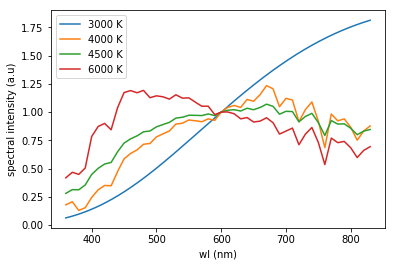

In [2]:
#----------------------------------------------------------------------------------------------------
# set CIE observer:
cieobs = '1964_10'

#----------------------------------------------------------------------------------------------------
# get BB, DL & cierf ref:
ccts = [3000,4000,4500, 6000] #define M = 4 ccts
ref_types = ['BB','DL','cierf','DL'] # define reference illuminant types
REF = lx.cri_ref(ccts, ref_type = ref_types, norm_type = 'lambda', norm_f = 600) # calculate reference illuminants

print("\n-----------------------------------------------------------------------------------------------")
print("Get M = 4 BB, DL & cierf reference illuminants at ccts = [3000,4000,4500, 6000], \
      \nnormalize to 1 at wavelength = 600 and store in REF:")
print("* CODE 1: ccts = [3000,4000,4500, 6000]")
print("* CODE 2: ref_types = ['BB','DL','cierf','DL']")
print("* CODE 3: REF = lx.cri_ref(ccts, ref_type = ref_types, norm_type = 'lambda', norm_f = 600)")
print('* REF.shape --> (M + 1 x number of wavelengths): {}'.format(REF.shape))


#----------------------------------------------------------------------------------------------------
# Interpolate light source spectra REF according to CIE15-2004 to a 400 nm - 700 nm range with a 5 nm spacing:
# (kind = 'S') defines the input is a light source spectrum and should be interpolated using a 'cubic spline'
REFi = lx.cie_interp(REF, wl_new = np.arange(400,700+1,5), kind = 'S') 
print('* REFi.shape --> (M + 1 x number of wavelengths): {}'.format(REFi.shape))

#----------------------------------------------------------------------------------------------------
# Get XYZ of a set of light sources only:
xyz_REF = lx.spd_to_xyz(REF,cieobs = cieobs) # direct calculation of illuminant xyz

print("\n-----------------------------------------------------------------------------------------------")
print('Get XYZ of a set of light sources (REF) only, xyz_REF:')
print('* CODE: xyz_REF = lx.spd_to_xyz(REF,cieobs = cieobs)')
print('* xyz_REF.shape --> (M x 3): {}'.format(xyz_REF.shape))


#----------------------------------------------------------------------------------------------------
# Get XYZ of a set of spectral reflectance functions 'illuminated' by a set of light sources:
TCS8 = lx._CRI_RFL['cie-13.3-1995']['8'] # get 8 spectral reflectance functions used in CIE 13.3-1995
xyz_TCS8_REF = lx.spd_to_xyz(REF,cieobs = cieobs, rfl = TCS8, relative = True) # direct calculation of illuminant xyz

print("\n-----------------------------------------------------------------------------------------------")
print('Get set of spectral reflectance functions:')
print("* CODE: TCS8 = lx._CRI_RFL['cie-13.3-1995']['8']")
print('* TCS8.shape: {} --> (N + 1 x number of wavelengths)'.format(TCS8.shape))

print("\nGet XYZ and XYZw of a set of spectral reflectance functions illuminated' by a set of light sources:")
print("* CODE: xyz_TCS8_REF = lx.spd_to_xyz(REF,cieobs = cieobs, rfl = TCS8,relative = True)")
print('\nXYZ of spectral refl. fcns illuminated by REF, xyz_TCS8_REF:')
print('* xyz_TCS8_REF.shape --> (N x M x 3): {}'.format(xyz_TCS8_REF.shape))


#----------------------------------------------------------------------------------------------------
# Get XYZ and XYZw of a set of spectral reflectance functions 'illuminated' by a set of light sources:
xyz_TCS8_REF_2, xyz_REF_2 = lx.spd_to_xyz(REF,cieobs = cieobs, rfl = TCS8, relative = True, out = 2) # direct calculation of illuminant xyz

# or 
# as follows, whereby the command is split over two lines
# (make sure no character or white space follows the line separator character '\'):
xyz_TCS8_REF_2, xyz_REF_2 = lx.spd_to_xyz(REF, cieobs = cieobs, rfl = TCS8, \
                                          relative = True, out = 2)

print("\n-----------------------------------------------------------------------------------------------")
print("Get XYZ and XYZw of a set of spectral reflectance functions illuminated' by a set of light sources:")
print("* CODE: xyz_TCS88_REF_2, xyz_REF_2 = lx.spd_to_xyz(REF,cieobs = cieobs, rfl = TCS8, relative = True, out = 2)")
print('* xyz_TCS8_REF_2.shape --> (N x M x 3): {}'.format(xyz_TCS8_REF_2.shape))
print('* xyz_REF_2.shape --> (M x 3): {}'.format(xyz_REF_2.shape))


#----------------------------------------------------------------------------------------------------
print("\n-----------------------------------------------------------------------------------------------")
print('Spectrum plot of reference illuminants REF, normalized to 1 at wl = 600 nm:')
plt.plot(REF[0],REF[1:].T)
plt.xlabel('wl (nm)')
plt.ylabel('spectral intensity (a.u)')
plt.legend(['{} K'.format(x) for x in ccts])
plt.show()

#----------------------------------------------------------------------------------------------------
# See also section on usage of Class SPD below

### colortransforms.py: xyz_to_Yuv(), ...


-----------------------------------------------------------------------------------------------
Calculate Yuv (CIE 1976 u'v') from xyz (identical for other transforms):
* CODE: Yuv_REF_2 = lx.xyz_to_Yuv(xyz_REF_2)
* Yuv_REF_2.shape --> (M x 3): (4, 3)
* Yuv_TCS8_REF_2.shape --> (N x M x 3): (8, 4, 3)

-----------------------------------------------------------------------------------------------
Plot spectrum locus (together with blackbody and daylight locus):
* CODE: axh = lx.plotSL(cspace='Yuv', cieobs = cieobs,show = False, BBL = True, DL = True)

Split Yuv in Y,u,v for plotting:
* CODE: Y, u,v = np.squeeze(lx.asplit(Yuv_REF_2))

Plot Yuv data in graph:
* CODE: lx.plot_color_data(u,v, formatstr = 'go')


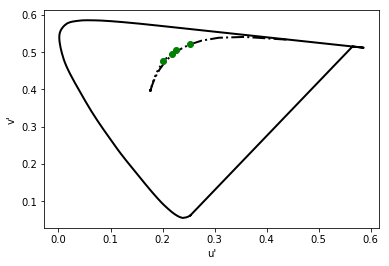

In [3]:
#----------------------------------------------------------------------------------------------------
# calculate Yuv (CIE 1976 u'v') from xyz (identical for other transforms):
Yuv_REF_2 = lx.xyz_to_Yuv(xyz_REF_2)
Yuv_TCS8_REF_2 = lx.xyz_to_Yuv(xyz_TCS8_REF_2)

print("\n-----------------------------------------------------------------------------------------------")
print("Calculate Yuv (CIE 1976 u'v') from xyz (identical for other transforms):")
print("* CODE: Yuv_REF_2 = lx.xyz_to_Yuv(xyz_REF_2)")
print("* Yuv_REF_2.shape --> (M x 3): {}".format(Yuv_REF_2.shape))
print("* Yuv_TCS8_REF_2.shape --> (N x M x 3): {}".format(Yuv_TCS8_REF_2.shape))

#----------------------------------------------------------------------------------------------------
# plot spectrum locus (together with blackbody and daylight locus):
print("\n-----------------------------------------------------------------------------------------------")
print("Plot spectrum locus (together with blackbody and daylight locus):")
print("* CODE: axh = lx.plotSL(cspace='Yuv', cieobs = cieobs,show = False, BBL = True, DL = True)")
axh = lx.plotSL(cspace='Yuv', cieobs = cieobs,show = False, BBL = True, DL = True)


print("\nSplit Yuv in Y,u,v for plotting:")
print("* CODE: Y, u,v = np.squeeze(lx.asplit(Yuv_REF_2))")
Y, u,v = np.squeeze(lx.asplit(Yuv_REF_2)) # splits array along last axis

print("\nPlot Yuv data in graph:")
print("* CODE: lx.plot_color_data(u,v, formatstr = 'go')")
lx.plot_color_data(u,v, formatstr = 'go')

#----------------------------------------------------------------------------------------------------
# See also section on usage of Classes XYZ and LAB below

### colortf.py:  colortf()

In [4]:
#----------------------------------------------------------------------------------------------------
# Use of colortf (works for any transformation that has can be mapped as ..._to_xyz() --> xyz_to_...()):
print("Use of colortf (works for any transformation that has can be mapped as ..._to_xyz() --> xyz_to_...()):")


#----------------------------------------------------------------------------------------------------
# colortf() calls xyz_to...() function that doesn't require extra parameter input:
print("\n-----------------------------------------------------------------------------------------------")
print("Colortf() calls xyz_to...() function that doesn't require extra parameter input:")

# Yuv from xyz:
print("Example 1: xyz --> Yuv: direct call to xyz_to_Yuv(xyz):")
print("* CODE: Yuv_REF = lx.colortf(xyz_REF_2, tf = 'Yuv')")
Yuv_REF = lx.colortf(xyz_REF_2, tf = 'Yuv') #start from xyz (equivalent to tf = 'xyz>Yuv')
print("Yuv_REF.shape --> (Nx3):{}".format(Yuv_REF.shape))

# Yuv from spd:
print("\nExample 2:  spd --> Yuv: 2 calls: xyz_to_Yuv(spd_to_xyz(spd)):")
print("* CODE: Yuv_REF = lx.colortf(REF, tf = 'spd>Yuv')")
Yuv_REF = lx.colortf(REF, tf = 'spd>Yuv')
print("Yuv_REF.shape --> (Nx3):{}".format(Yuv_REF.shape))


#----------------------------------------------------------------------------------------------------
# colortf() calls xyz_to...() function that does require extra parameter input (through fwtf dict):
print("\n-----------------------------------------------------------------------------------------------")
print("Colortf() calls xyz_to...() function that does require extra parameter input (through fwtf dict)")


# L*a*b* (CIELAB) from xyz (using default whitepoint xyzw as set in xyz_to_lab()):
print("L*a*b* (CIELAB) from xyz (using default whitepoint xyzw (D65) as set in xyz_to_lab())")
print("* CODE: lab_REF1 = lx.colortf(xyz_REF_2, tf = 'lab')")
lab_REF1 = lx.colortf(xyz_REF_2, tf = 'lab') #start from xyz (equivalent to tf = 'xyz>lab')
print('Output:\n{}'.format(lab_REF1))
print('\nlab of light sources --> shape of lab_REF1 (Nx3): {}'.format(lab_REF1.shape))

# L*a*b* (CIELAB) from Yuv (using dict input of user defined white point):
print("\n\nL*a*b* (CIELAB) from Yuv (using dict input of user defined white point):")
print("* CODE 1: fwtf_userdefined = {'xyzw' : lx.spd_to_xyz(lx._CIE_ILLUMINANTS['A'])}")
print("* CODE 2: lab_REF2 = lx.colortf(Yuv_REF_2, tf = 'lab', fwtf = fwtf_userdefined)")
fwtf_userdefined = {'xyzw' : lx.spd_to_xyz(lx._CIE_ILLUMINANTS['A'])}
lab_REF2 = lx.colortf(xyz_REF_2, tf = 'lab', fwtf = fwtf_userdefined) #start from xyz (equivalent to tf = 'xyz>lab')
lab_REF2_2 = lx.colortf(Yuv_REF_2, tf = 'Yuv>lab', fwtf = fwtf_userdefined) #start from Yuv 
print('Output lab_REF2:\n{}'.format(lab_REF2))
print('Output lab_REF2_2:\n{}'.format(lab_REF2_2))
print('\nlab of light sources --> shape of lab_REF2 (Nx3): {}'.format(lab_REF2.shape))
print('\nlab of light sources --> shape of lab_REF2_2 (Nx3): {}'.format(lab_REF2_2.shape))

# or with entry directly as keyword arguments (only for forward transformations:)
print("\n\nL*a*b* (CIELAB) from Yuv (using direct input of user defined white point):")
lab_REF2_3 = lx.colortf(Yuv_REF_2, tf = 'Yuv>lab', xyzw = lx.spd_to_xyz(lx._CIE_ILLUMINANTS['A']))
print('Output lab_REF2_3:\n{}'.format(lab_REF2_3))

#----------------------------------------------------------------------------------------------------
# See also section on usage of Classes XYZ and LAB below

Use of colortf (works for any transformation that has can be mapped as ..._to_xyz() --> xyz_to_...()):

-----------------------------------------------------------------------------------------------
Colortf() calls xyz_to...() function that doesn't require extra parameter input:
Example 1: xyz --> Yuv: direct call to xyz_to_Yuv(xyz):
* CODE: Yuv_REF = lx.colortf(xyz_REF_2, tf = 'Yuv')
Yuv_REF.shape --> (Nx3):(4, 3)

Example 2:  spd --> Yuv: 2 calls: xyz_to_Yuv(spd_to_xyz(spd)):
* CODE: Yuv_REF = lx.colortf(REF, tf = 'spd>Yuv')
Yuv_REF.shape --> (Nx3):(4, 3)

-----------------------------------------------------------------------------------------------
Colortf() calls xyz_to...() function that does require extra parameter input (through fwtf dict)
L*a*b* (CIELAB) from xyz (using default whitepoint xyzw (D65) as set in xyz_to_lab())
* CODE: lab_REF1 = lx.colortf(xyz_REF_2, tf = 'lab')
Output:
[[100.          23.9753864   57.97069026]
 [100.           9.02919393  35.98843749]
 [100.    

### cct.py: xyz_to_cct(), cct_to_xyz():

In [11]:
#----------------------------------------------------------------------------------------------------
# calculate cct & duv of set of sources:
print("\nGet cct and duv:")

#----------------------------------------------------------------------------------------------------
# Using Ohno's LUT method:
print("\n-----------------------------------------------------------------------------------------------")
print("using Ohno's method with Look-Up-Table (LUT):")
print("* CODE: cct_ohno, duv_ohno = lx.xyz_to_cct(xyz_REF_2,cieobs = cieobs, out = 'cct,duv', mode = 'lut')")
cct_ohno, duv_ohno = lx.xyz_to_cct(xyz_REF_2,cieobs = cieobs, out = 'cct,duv', mode = 'lut') #use Ohno's approach with Look-Up-Table

print("\nResults: xyz_to_cct(..., mode = 'lut') (use Ohno's method):")
print('\nOhno: cct:\n{}'.format(cct_ohno))
print('\nOhno: duv:\n{}'.format(duv_ohno))
print('\nTime for xyz_to_cct_ohno() to run:')
%timeit cct_ohno, duv_ohno = lx.xyz_to_cct(xyz_REF_2,cieobs = cieobs, out = 'cct,duv', mode = 'lut') #use Ohno's approach with Look-Up-Table

#----------------------------------------------------------------------------------------------------
# Using a brute-force search method:
print("\n-----------------------------------------------------------------------------------------------")
print("using a brute-force search):")
print("* CODE: cct_search, duv_search = lx.xyz_to_cct(xyz_REF_2,cieobs = cieobs, out = 'cct,duv', mode = 'search') ")
cct_search, duv_search = lx.xyz_to_cct(xyz_REF_2,cieobs = cieobs, out = 'cct,duv', mode = 'search') #use brute-force search approach

print("\nResults: xyz_to_cct(..., mode = 'search') (use brute force search method):")
print('\nSearch: cct:\n{}'.format(cct_search))
print('\nSearch: duv:\n{}'.format(duv_search))
print('\nTime for xyz_to_cct_search() to run:')
%timeit cct_search, duv_search = lx.xyz_to_cct(xyz_REF_2,cieobs = cieobs, out = 'cct,duv', mode = 'search') #use brute-force search approach


#----------------------------------------------------------------------------------------------------
# Calculate xyz from cct & duv:
print("\n-----------------------------------------------------------------------------------------------")
xyz_REF_2_ohno = lx.cct_to_xyz(cct_ohno,duv = duv_ohno, cieobs = cieobs, mode = 'lut') #use Ohno's approach with Look-Up-Table
xyz_REF_2_search = lx.cct_to_xyz(cct_search, duv = duv_search, cieobs = cieobs, mode = 'search') #use brute-force search approach

print("Calculate xyz from cct & duv:")
print('\ncct_to_xyz():')
print('\nAgreement between forward (xyz_to_cct) and inverse (cct_to_xyz):')
print('\nOhno: xyzREF_2 - xyz_REF_2_ohno:\n{}'.format(xyz_REF_2 - xyz_REF_2_ohno))
print('\nSearch: xyzREF_2 - xyz_REF_2_search:\n{}'.format(xyz_REF_2 - xyz_REF_2_search))

print('\nTime for cct_to_xyz_ohno() to run:')
%timeit xyz_REF_2_ohno = lx.cct_to_xyz(cct_ohno,duv = duv_ohno, cieobs = cieobs, mode = 'lut') #use Ohno's approach with Look-Up-Table

print('\nTime for cct_to_xyz_search() to run:')
%timeit xyz_REF_2_search = lx.cct_to_xyz(cct_search, duv = duv_search, cieobs = cieobs, mode = 'search') #use brute-force search approach






Get cct and duv:

-----------------------------------------------------------------------------------------------
using Ohno's method with Look-Up-Table (LUT):
* CODE: cct_ohno, duv_ohno = lx.xyz_to_cct(xyz_REF_2,cieobs = cieobs, out = 'cct,duv', mode = 'lut')

Results: xyz_to_cct(..., mode = 'lut') (use Ohno's method):

Ohno: cct:
[[2999.73320996]
 [3996.76148586]
 [4494.92213738]
 [5980.52360684]]

Ohno: duv:
[[5.04645189e-08]
 [3.08475171e-03]
 [1.67273402e-03]
 [3.45039551e-03]]

Time for xyz_to_cct_ohno() to run:
434 µs ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

-----------------------------------------------------------------------------------------------
using a brute-force search):
* CODE: cct_search, duv_search = lx.xyz_to_cct(xyz_REF_2,cieobs = cieobs, out = 'cct,duv', mode = 'search') 

Results: xyz_to_cct(..., mode = 'search') (use brute force search method):

Search: cct:
[[2999.97339539]
 [3997.12250211]
 [4495.31152414]
 [5980.98351851]]

Search: 

### chromaticadaptation.py

-----------------------------------------------------------------------------------------------
Calculate corresponding colors using a chromatic adaptation transform
Supported: von kries diagonal tf and rlab type.

--> Convert xyz_TCS8_REF to xyz_TCS8 under D65 using 2-step von Kries with cat02 sensor primaries,
with D automatically calculated from La = 100 cd/m²
* CODE: xyz_TCS8_REF_c = lx.cat.apply(xyz_TCS8_REF, xyzw1 = xyzw1, xyzw2 = xyzw2, catmode='1>0>2', cattype='vonkries', D = None, La = 100)

-----------------------------------------------------------------------------------------------
Plot results in CIE u'v' diagram and add spectrum locus
* CODE 1: ax = plt.figure().add_subplot(111)
* CODE 2: ax.plot(Yuv_TCS8_REF[:,0,1],Yuv_TCS8_REF[:,0,2],color ='r',marker = 'o', linestyle = 'none')
* CODE 3: ax.plot(Yuv_TCS8_REF_c[:,0,1],Yuv_TCS8_REF_c[:,0,2],color ='b',marker ='d', linestyle = 'none')
* CODE 4: ax.set_xlabel("u'")
* CODE 5: ax.set_ylabel("v'")")

and add Spectrum Locus an

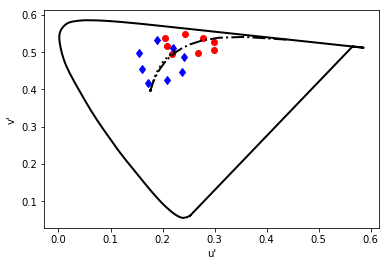

In [5]:
#----------------------------------------------------------------------------------------------------
# Calculate corresponding colors:
print("-----------------------------------------------------------------------------------------------")
print("Calculate corresponding colors using a chromatic adaptation transform")
print("Supported: von kries diagonal tf and rlab type.")
print("\n--> Convert xyz_TCS8_REF to xyz_TCS8 under D65 using 2-step von Kries with cat02 sensor primaries,")
print("with D automatically calculated from La = 100 cd/m²")
xyzw1 = xyz_REF # original illumination condition
xyzw2 = lx.spd_to_xyz(lx._CIE_ILLUMINANTS['D65'], cieobs = cieobs, relative = True) #new illumination condition

print("* CODE: xyz_TCS8_REF_c = lx.cat.apply(xyz_TCS8_REF, xyzw1 = xyzw1, xyzw2 = xyzw2, catmode='1>0>2', cattype='vonkries', D = None, La = 100)")
xyz_TCS8_REF_c = lx.cat.apply(xyz_TCS8_REF, xyzw1 = xyzw1, xyzw2 = xyzw2, catmode='1>0>2', cattype='vonkries', D = None, La = 100)
xyz_TCS8_REF_c2 = lx.cat.apply(xyz_TCS8_REF, xyzw1 = xyzw1, xyzw2 = xyzw2, catmode='1>0>2', cattype='vonkries', D = None, La = np.array([[100,1000]]))

#----------------------------------------------------------------------------------------------------
print("\n-----------------------------------------------------------------------------------------------")
# plot results for first illuminant in CIE 1976 u'v' diagram:
Yuv_TCS8_REF = lx.xyz_to_Yuv(xyz_TCS8_REF)
Yuv_TCS8_REF_c = lx.xyz_to_Yuv(xyz_TCS8_REF_c)
Yuv_TCS8_REF_c2 = lx.xyz_to_Yuv(xyz_TCS8_REF_c2)

#Plot results for illuminant 0:
print("Plot results in CIE u'v' diagram and add spectrum locus")
ax = plt.figure().add_subplot(111)
ax.plot(Yuv_TCS8_REF[:,0,1],Yuv_TCS8_REF[:,0,2],color ='r',marker = 'o', linestyle = 'none')
ax.plot(Yuv_TCS8_REF_c[:,0,1],Yuv_TCS8_REF_c[:,0,2],color ='b',marker ='d', linestyle = 'none')
#ax.plot(Yuv_TCS8_REF_c2[:,0,1],Yuv_TCS8_REF_c2[:,0,2],color ='g',marker ='s', linestyle = 'none')
ax.set_xlabel("u'")
ax.set_ylabel("v'")
print("* CODE 1: ax = plt.figure().add_subplot(111)")
print("* CODE 2: ax.plot(Yuv_TCS8_REF[:,0,1],Yuv_TCS8_REF[:,0,2],color ='r',marker = 'o', linestyle = 'none')")
print("* CODE 3: ax.plot(Yuv_TCS8_REF_c[:,0,1],Yuv_TCS8_REF_c[:,0,2],color ='b',marker ='d', linestyle = 'none')")
print("""* CODE 4: ax.set_xlabel("u'")""")
print("""* CODE 5: ax.set_ylabel("v'")")""")

#----------------------------------------------------------------------------------------------------
# add spectrum locus and Daylight and Planckian loci:
print("\nand add Spectrum Locus and Daylight Locus (DL = True) and BlackBody Locus (BBL = True) for cieobs = cieobs;")
print("* CODE: lx.plotSL(cieobs = cieobs, cspace = 'Yuv', DL = True, BBL = True)")
lx.plotSL(cieobs = cieobs, cspace = 'Yuv', DL = True, BBL = True)


### colorappearancemodels.py: 

-----------------------------------------------------------------------------------------------
Convert xyz_TCS8_REF to ciecam02 J, aM, bM:
* CODE: JabM = lx.xyz_to_jabM_ciecam02(xyz_TCS8_REF)

  JabM_TCS8_REF.shape --> (N x M x 3): (8, 4, 3)

-----------------------------------------------------------------------------------------------
Convert xyz_TCS8_REF to ciecam02 J, aM, bM using user specified viewing conditions:
* CODE: JabM_TCS8_REF_user = lx.xyz_to_jabM_ciecam02(xyz_TCS8_REF, xyzw = xyzw2, conditions = user_conditions)

  JabM_TCS8_REF_user.shape --> (N x M x 3): (8, 4, 3)

-----------------------------------------------------------------------------------------------
Plot results:
* CODE 1: ax = plt.figure().add_subplot(111,projection = '3d')
* CODE 2: ax.plot(JabM_TCS8_REF[:,0,1],JabM_TCS8_REF[:,0,2],JabM_TCS8_REF[:,0,0],color ='r',marker = 'o')
* CODE 3: ax.plot(JabM_TCS8_REF_user[:,0,1],TCS8_REF_user[:,0,2],JabM_TCS8_REF_user[:,0,0],color ='b',marker ='d')
* CODE 4: ax.se

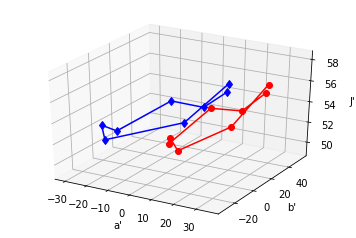

In [9]:
#----------------------------------------------------------------------------------------------------
# Convert xyz_TCS8_REF to ciecam02 J, aM, bM:
JabM_TCS8_REF = lx.xyz_to_jabM_ciecam02(xyz_TCS8_REF)

print("-----------------------------------------------------------------------------------------------")
print("Convert xyz_TCS8_REF to ciecam02 J, aM, bM:")
print("* CODE: JabM = lx.xyz_to_jabM_ciecam02(xyz_TCS8_REF)")
print("\n  JabM_TCS8_REF.shape --> (N x M x 3): {}".format(JabM_TCS8_REF.shape))


#----------------------------------------------------------------------------------------------------
# Convert xyz_TCS8_REF to ciecam02 J, aM, bM using user specified viewing conditions:
xyzw = xyz_REF#lx.spd_to_xyz(lx._CIE_ILLUMINANTS['D65'])
user_conditions = {'D': None, 'Dtype': None, 'La': 500.0, 'Yb': 40.0, 'surround': 'dim'} # see lx.cam._CAM_DEFAULT_CONDITIONS for details on structure of dict
JabM_TCS8_REF_user = lx.xyz_to_jabM_ciecam02(xyz_TCS8_REF, xyzw = xyzw, conditions = user_conditions)

print("\n-----------------------------------------------------------------------------------------------")
print("Convert xyz_TCS8_REF to ciecam02 J, aM, bM using user specified viewing conditions:")
print("* CODE: JabM_TCS8_REF_user = lx.xyz_to_jabM_ciecam02(xyz_TCS8_REF, xyzw = xyzw2, conditions = user_conditions)")
print("\n  JabM_TCS8_REF_user.shape --> (N x M x 3): {}".format(JabM_TCS8_REF_user.shape))


#----------------------------------------------------------------------------------------------------
#Plot results:
print("\n-----------------------------------------------------------------------------------------------")
print("Plot results:")
ax = plt.figure().add_subplot(111,projection = '3d')
ax.plot(JabM_TCS8_REF[:,0,1],JabM_TCS8_REF[:,0,2],JabM_TCS8_REF[:,0,0],color ='r',marker = 'o')
ax.plot(JabM_TCS8_REF_user[:,0,1],JabM_TCS8_REF_user[:,0,2],JabM_TCS8_REF_user[:,0,0],color ='b',marker ='d')
ax.set_zlabel("J'")
ax.set_xlabel("a'")
ax.set_ylabel("b'")

print("* CODE 1: ax = plt.figure().add_subplot(111,projection = '3d')")
print("* CODE 2: ax.plot(JabM_TCS8_REF[:,0,1],JabM_TCS8_REF[:,0,2],JabM_TCS8_REF[:,0,0],color ='r',marker = 'o')")
print("* CODE 3: ax.plot(JabM_TCS8_REF_user[:,0,1],TCS8_REF_user[:,0,2],JabM_TCS8_REF_user[:,0,0],color ='b',marker ='d')")
print("""* CODE 4: ax.set_zlabel("J'")""")
print("""* CODE 5: ax.set_xlabel("a'")""")
print("""* CODE 6: ax.set_ylabel("b'")""")



#----------------------------------------------------------------------------------------------------
# See also section on usage of Classes XYZ and LAB below

###### cri.py:

In [17]:
#----------------------------------------------------------------------------------------------------
# Get some spectra:
spds = lx._IESTM30['S']['data'][:4+1] # get first 4 spds from IESTM30 database

print("-----------------------------------------------------------------------------------------------")
print("Get first 4 spectra from IESTM30 database:")
print("* CODE: SPD = lx._IESTM30['S']['data'][:4+1] ")
print('\nPrint SPD info:')
print("* CODE: lx._IESTM30['S']['info'][:N][:,1])") #print SPD info
print(lx._IESTM30['S']['info'][:4][:,1]) #print SPD info

print("\n\n-----------------------------------------------------------------------------------------------")
print("\Calculate CIE13.3-1995 Ra:")
print("* CODE: ciera = lx.cri.spd_to_ciera(spds)")
ciera = lx.cri.spd_to_ciera(spds)
print('- CIE13.3-1995 Ra:')
print(ciera)

print("\n-----------------------------------------------------------------------------------------------")
print("Calculate CIE224-2017 Rf:")
print("* CODE: cierf = lx.cri.spd_to_cierf(spds)")
cierf = lx.cri.spd_to_cierf(spds)
print('- CIE224-2017 Rf:')
print(cierf)

print("\n-----------------------------------------------------------------------------------------------")
print("Calculate IES TM30-15 Rf:") #TM30-15
print("* CODE: iesrf = lx.cri.spd_to_iesrf(spds, cri_type = 'iesrf-tm30-15')")
iesrf_15 = lx.cri.spd_to_iesrf(spds, cri_type = 'iesrf-tm30-15')
print('- IES TM30-15 Rf:')
print(iesrf_15)

print("\n-----------------------------------------------------------------------------------------------")
print("Calculate IES TM30-15 Rg:") #TM30-15 
print("* CODE: iesrf = lx.cri.spd_to_iesrg(spds,cri_type = 'iesrf-tm30-15')")
iesrg_15 = lx.cri.spd_to_iesrg(spds, cri_type = 'iesrf-tm30-15')
print('- IES TM30-15 Rg:')
print(iesrg_15)

print("\n-----------------------------------------------------------------------------------------------")
print("Calculate IES TM30-18 Rf:") #TM30-18
print("* CODE: iesrf = lx.cri.spd_to_iesrf(spds)")
iesrf = lx.cri.spd_to_iesrf(spds)
print('- IES TM30-18 Rf:')
print(iesrf)

print("\n-----------------------------------------------------------------------------------------------")
print("Calculate IES TM30-18 Rg:") #TM30-18 
print("* CODE: iesrf = lx.cri.spd_to_iesrg(spds)")
iesrg = lx.cri.spd_to_iesrg(spds)
print('- IES TM30-18 Rg:')
print(iesrg)

cri_type = 'iesrf'
cierf_new = lx.cri.spd_to_cri(spds, cri_type = cri_type, avg = np.mean,\
                                sampleset = eval("lx._CRI_RFL['ies-tm30']['4880']['5nm']"),\
                                ref_type = 'BB')


-----------------------------------------------------------------------------------------------
Get first 4 spectra from IESTM30 database:
* CODE: SPD = lx._IESTM30['S']['data'][:4+1] 

Print SPD info:
* CODE: lx._IESTM30['S']['info'][:N][:,1])
[' CIE F1' ' CIE F2' ' CIE F3' ' CIE F4']


-----------------------------------------------------------------------------------------------
\Calculate CIE13.3-1995 Ra:
* CODE: ciera = lx.cri.spd_to_ciera(spds)
- CIE13.3-1995 Ra:
[[75.8779463  64.2655959  56.82304187 51.51608131]]

-----------------------------------------------------------------------------------------------
Calculate CIE224-2017 Rf:
* CODE: cierf = lx.cri.spd_to_cierf(spds)
- CIE224-2017 Rf:
[[80.69633759 70.2285115  63.21964907 56.86183218]]

-----------------------------------------------------------------------------------------------
Calculate IES TM30-15 Rf:
* CODE: iesrf = lx.cri.spd_to_iesrf(spds, cri_type = 'iesrf-tm30-15')
- IES TM30-15 Rf:
[[78.37345599 66.64808417 58

KeyError: 'ies-tm30'

-----------------------------------------------------------------------------------------------
Calculate and plot IES TM30 color rendition measures:
* CODE: data = lx.cri.plot_cri_graphics(SPD)


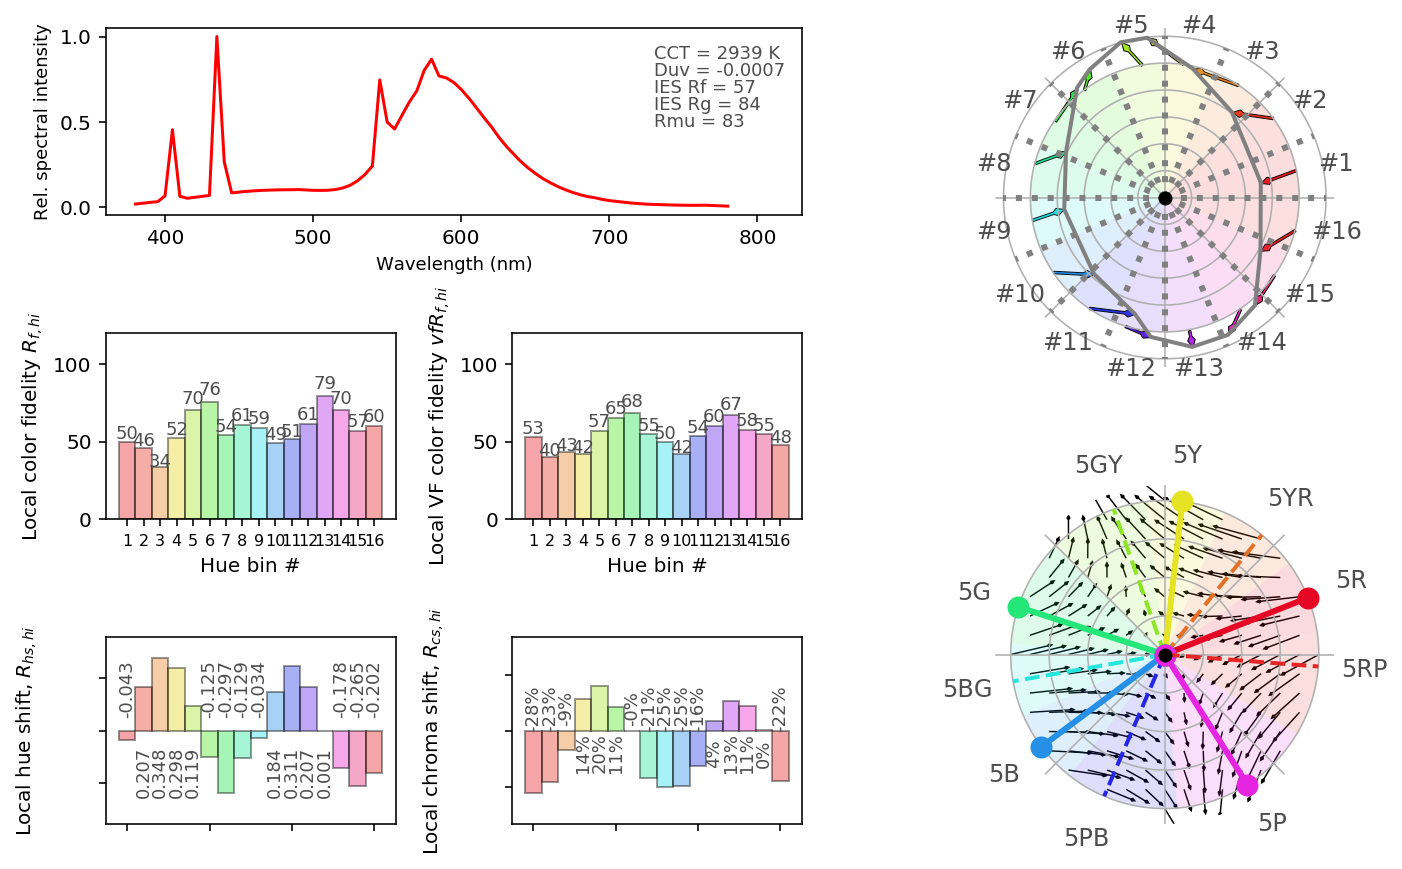

In [5]:
#----------------------------------------------------------------------------------------------------
# Calculate and plot IES TM30 color rendition measures:
SPD = lx._CIE_ILLUMINANTS['F4']
data = lx.cri.plot_cri_graphics(SPD)

print("-----------------------------------------------------------------------------------------------")
print("Calculate and plot IES TM30 color rendition measures:")
print("* CODE: data = lx.cri.plot_cri_graphics(SPD)")


-----------------------------------------------------------------------------------------------
Calculate and plot IES TM30 color rendition measures and change some of the default plotting options:
* CODE: data = lx.cri.plot_cri_graphics(SPD, plot_bin_colors = False, vf_plot_bin_colors = False, vf_color = 'grey',plot_CF = True)


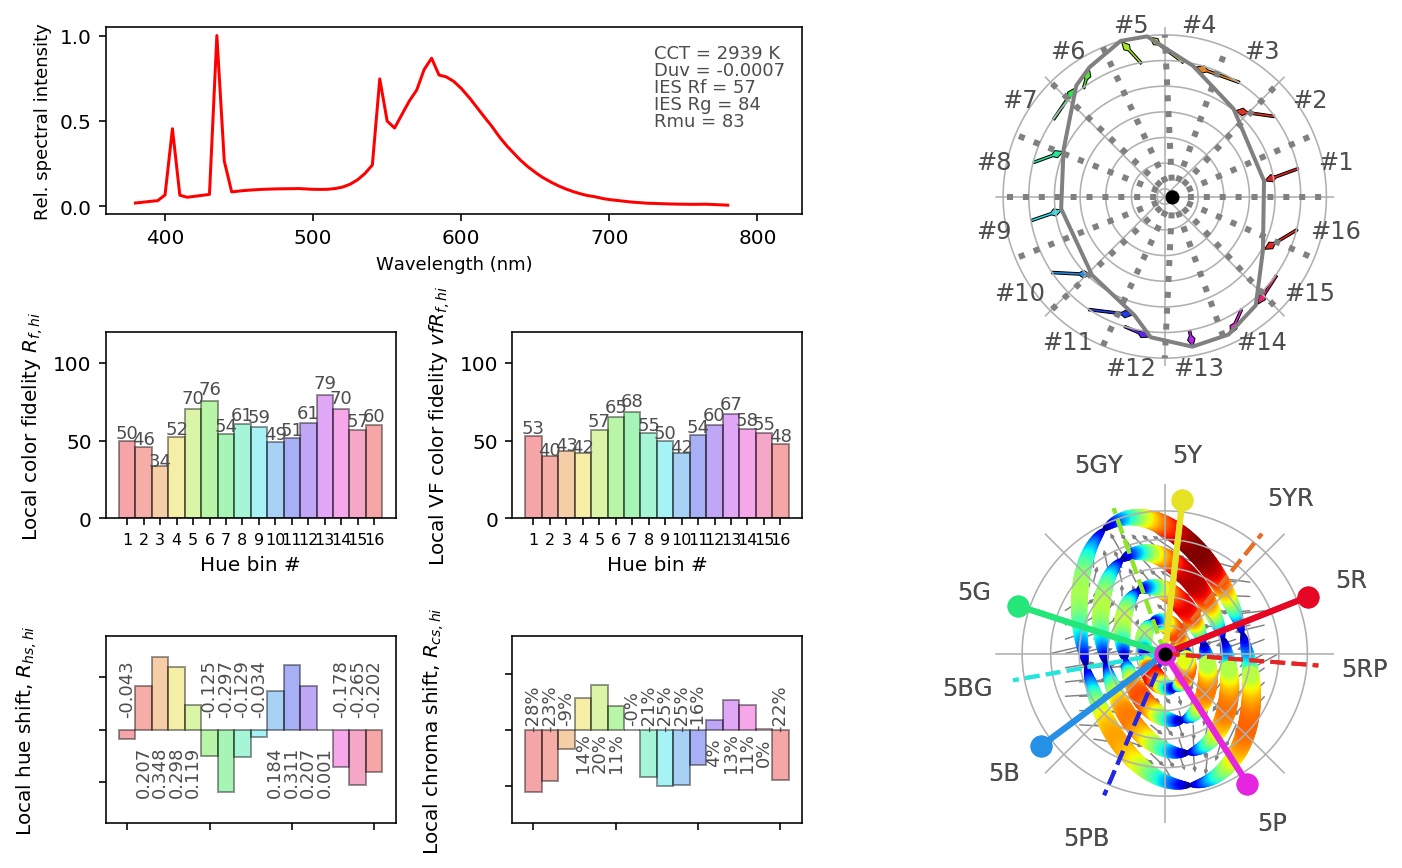

In [4]:
#----------------------------------------------------------------------------------------------------
#Calculate and plot IES TM30 color rendition measures and change some of the default plotting options
SPD = lx._CIE_ILLUMINANTS['F4']
data = lx.cri.plot_cri_graphics(SPD, plot_bin_colors = False, vf_plot_bin_colors = False, vf_color = 'grey',plot_CF = True)

print("-----------------------------------------------------------------------------------------------")
print("Calculate and plot IES TM30 color rendition measures and change some of the default plotting options:")
print("* CODE: data = lx.cri.plot_cri_graphics(SPD, plot_bin_colors = False, vf_plot_bin_colors = False, vf_color = 'grey',plot_CF = True)")


### Classes SPD, XYZ and LAB:

Class SPD usage:

-----------------------------------------------------------------------------------------------
Convert REF numpy.ndarray with spectral light source data (dtype = 'S') to instance of class SPD,
 interpolate to a 400-700 nm range and normalize to unit area:
* CODE: REFo = SPD(REF, dtype = 'S').cie_interp(wl_new = np.arange(400,700+1, 1)).normalize(norm_type = 'area')

   Type of spectral data can be stored in .dtype field: S
   Wavelength are in .wl field: (301,)
   Value are in .value field: (4, 301)
   Number of spds is contained in .N field: 4
   Shape of REFo.value is in .shape field: (4, 471)

-----------------------------------------------------------------------------------------------
Calculate relative xyz values using CIE 1964 10° Color Matching Functions:
  Output is an instance of class XYZ (with fields: value, relative, cieobs,, dtype and shape.
* CODE: xyzo = REFo.to_xyz(cieobs = '1964_10', relative = True)
   Shape of xyzo.values: (4, 471)

-------------

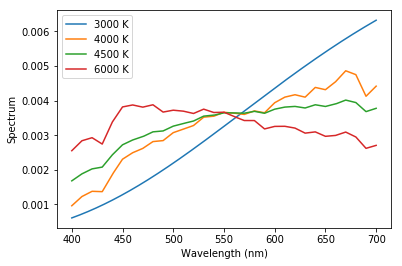

In [8]:
## SPD class #################################################################################################
print("Class SPD usage:")

#----------------------------------------------------------------------------------------------------
# Convert REF numpy.ndarray with spectral light source data (dtype = 'S') to instance of class SPD,
# interpolate to a 400-700 nm range and normalize to unit area:
REFo = lx.SPD(REF, dtype = 'S').cie_interp(wl_new = np.arange(400,700+1, 1)).normalize(norm_type = 'area')

print("\n-----------------------------------------------------------------------------------------------")
print("Convert REF numpy.ndarray with spectral light source data (dtype = 'S') to instance of class SPD,")
print(" interpolate to a 400-700 nm range and normalize to unit area:")
print("* CODE: REFo = SPD(REF, dtype = 'S').cie_interp(wl_new = np.arange(400,700+1, 1)).normalize(norm_type = 'area')")
print("\n   Type of spectral data can be stored in .dtype field: {}".format(REFo.dtype))
print("   Wavelength are in .wl field: {}".format(REFo.wl.shape))
print("   Value are in .value field: {}".format(REFo.value.shape))
print("   Number of spds is contained in .N field: {}".format(REFo.N))
print("   Shape of REFo.value is in .shape field: {}".format(REFo.shape))


#----------------------------------------------------------------------------------------------------
# Calculate xyz:
xyzo = REFo.to_xyz(cieobs = '1964_10', relative = True)

print("\n-----------------------------------------------------------------------------------------------")
print("Calculate relative xyz values using CIE 1964 10° Color Matching Functions:")
print("  Output is an instance of class XYZ (with fields: value, relative, cieobs,, dtype and shape.")
print("* CODE: xyzo = REFo.to_xyz(cieobs = '1964_10', relative = True)")
print("   Shape of xyzo.values: {}".format(REFo.shape))


#----------------------------------------------------------------------------------------------------
# Plot spectral data of REFo object:
REFo.plot()
plt.legend(['{} K'.format(x) for x in ccts])

print("\n-----------------------------------------------------------------------------------------------")
print("Plot spectral data of REFo:")
print("* CODE: REFo.plot()")



Class XYZ usage:

-----------------------------------------------------------------------------------------------
Convert xyzo (instance of XYZ) to Yuv (instance of LAB)
* CODE: xyzo.to_Yuv()

   or alternatively:

* CODE: xyzo.ctf(dtype = 'Yuv')

-----------------------------------------------------------------------------------------------
Create XYZ instance with xyz from Munsell samples under Ref illuminants and convert to CAM02UCS J',a'b' (instance of LAB)
* CODE: Jabo_Munsell_ref = XYZ(xyz_Munsell8_REF, relative = relative, cieobs = cieobs).ctf(dtype = 'jab_cam02ucs')

-----------------------------------------------------------------------------------------------
Create plot of xyz values, Y on z-axis:
* CODE: xyzo.plot(color = 'g', title ='XYZ tristimulus values')


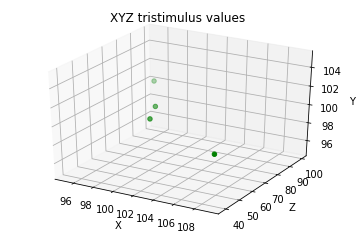

In [20]:
## XYZ & LAB class #################################################################################################
print("Class XYZ usage:")

#----------------------------------------------------------------------------------------------------
# Convert xyzo to Yuv:
Yuvo_a = xyzo.to_Yuv()
# or:
Yuvo_b = xyzo.ctf(dtype = 'Yuv')

print("\n-----------------------------------------------------------------------------------------------")
print("Convert xyzo (instance of XYZ) to Yuv (instance of LAB)")
print("* CODE: xyzo.to_Yuv()")
print("\n   or alternatively:")
print("\n* CODE: xyzo.ctf(dtype = 'Yuv')")


#----------------------------------------------------------------------------------------------------
# Create XYZ instance with xyz from Munsell samples under Ref illuminants and convert to CAM02UCS J',a'b' (instance of LAB):
Jabo_Munsell_ref = lx.XYZ(xyz_Munsell8_REF, relative = True, cieobs = cieobs).ctf(dtype = 'jab_cam02ucs')

print("\n-----------------------------------------------------------------------------------------------")
print("Create XYZ instance with xyz from Munsell samples under Ref illuminants and convert to CAM02UCS J',a'b' (instance of LAB)")
print("* CODE: Jabo_Munsell_ref = XYZ(xyz_Munsell8_REF, relative = relative, cieobs = cieobs).ctf(dtype = 'jab_cam02ucs')")
      

#----------------------------------------------------------------------------------------------------
# Plot xyzo:
xyzo.plot(color = 'g', title ='XYZ tristimulus values')

print("\n-----------------------------------------------------------------------------------------------")
print("Create plot of xyz values, Y on z-axis:")
print("* CODE: xyzo.plot(color = 'g', title ='XYZ tristimulus values')")




Class LAB usage:

-----------------------------------------------------------------------------------------------
Convert Yuv (instance of LAB) to xyzo (instance of XYZ)
* CODE: Yuvo.to_xyz()

   or alternatively:

* CODE:  Yuvo.ctf()

-----------------------------------------------------------------------------------------------
Create a 2d plot of Yuvo values, Y on z-axis:
* CODE: Yuvo_a.plot(color = 'm', plt_type = '2d', title = "CIE 1976 u',v' chromaticity values of ref. spds")




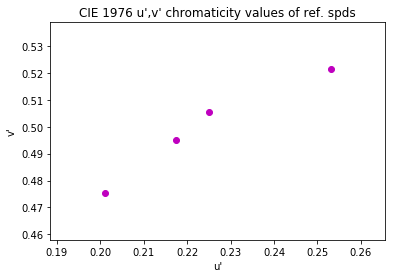


-----------------------------------------------------------------------------------------------
Create a 3d plot of Jabo_Munsell_ref values, J on z-axis:
* CODE: Jabo_Munsell_ref.plot(color = 'b', plt_type = '3d', title = "CAM02UCS J'a'b' of 8 Munsell samples under ref spds.")
Add the samples of the first (idx = 0) illuminant in a different color, marker symbol and size to the Jabo_Munsell_ref plot:
* CODE: Jabo_Munsell_ref.get_S(idx = 0).plot(ax = ax, color = 'r', s = 50, marker ='d')




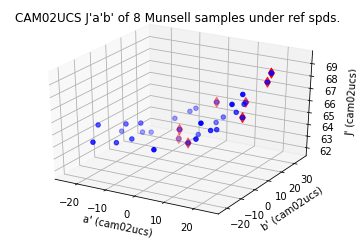

In [21]:
print("Class LAB usage:")

#----------------------------------------------------------------------------------------------------
# Convert Yuvo back to xyzo:
xyzo_a = Yuvo_a.to_xyz()
# or:
xyzo_b = Yuvo_b.ctf()

print("\n-----------------------------------------------------------------------------------------------")
print("Convert Yuv (instance of LAB) to xyzo (instance of XYZ)")
print("* CODE: Yuvo.to_xyz()")
print("\n   or alternatively:")
print("\n* CODE:  Yuvo.ctf()")


#----------------------------------------------------------------------------------------------------
# Plot Yuvo:
print("\n-----------------------------------------------------------------------------------------------")
print("Create a 2d plot of Yuvo values, Y on z-axis:")
print("""* CODE: Yuvo_a.plot(color = 'm', plt_type = '2d', title = "CIE 1976 u',v' chromaticity values of ref. spds")""")
print("\n")
Yuvo_a.plot(color = 'm', plt_type = '2d', title ="CIE 1976 u',v' chromaticity values of ref. spds")
plt.show()

#----------------------------------------------------------------------------------------------------
# Plot Jabo_Munsell_ref:
print("\n-----------------------------------------------------------------------------------------------")
print("Create a 3d plot of Jabo_Munsell_ref values, J on z-axis:")
print("""* CODE: Jabo_Munsell_ref.plot(color = 'b', plt_type = '3d', title = "CAM02UCS J'a'b' of 8 Munsell samples under ref spds.")""")
ax = Jabo_Munsell_ref.plot(color = 'b', plt_type = '3d', title = "CAM02UCS J'a'b' of 8 Munsell samples under ref spds.")


# Add to Jabo_Munsell_ref only the samples of the first illuminant in a different color
Jabo_Munsell_ref.get_S(idx = 0).plot(ax = ax, color = 'r', s = 50, marker ='d')

print("Add the samples of the first (idx = 0) illuminant in a different color, marker symbol and size to the Jabo_Munsell_ref plot:")
print("""* CODE: Jabo_Munsell_ref.get_S(idx = 0).plot(ax = ax, color = 'r', s = 50, marker ='d')""")
print("\n")

